# Analytic "dashboard" notebook to do some basic analysis on the song play data

In [1]:
import os
os.chdir('..')
import psycopg2
from psycopg2 import sql
import pandas as pd
from sql_queries import *
import matplotlib.pyplot as plt
import seaborn as sns
import configparser

In [2]:
config = configparser.ConfigParser()
config.read('dwh.cfg')

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()
print(conn)

<connection object at 0x7f9da18cfcd0; dsn: 'user=dwhuser password=xxx dbname=dwh host=dwhcluster.co7xh9ueeiob.us-west-2.redshift.amazonaws.com port=5439', closed: 0>


### Explore the solution dataset (the songplays table) where the artist and song columns are complete

In [3]:
query =("SELECT * FROM songplays \
        WHERE song_id IS NOT NULL \
        OR artist_id IS NOT NULL \
        ORDER BY start_time;")
cur.execute(query)
colnames = [desc[0] for desc in cur.description]
results = pd.DataFrame(cur.fetchall(), columns = colnames)
results

,songplay_id,start_time,user_id,level,song_id,artist_id,session_id,location,user_agent
0,4,2018-11-01 21:11:13.796,8,free,SOEIQUY12AF72A086A,ARHUC691187B9AD27F,139,"Phoenix-Mesa-Scottsdale, AZ","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK..."
1,585,2018-11-02 16:35:00.796,50,free,SOBONKR12A58A7A7E0,AR5E44Z1187B9A1D74,156,"New Haven-Milford, CT","""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK..."
2,596,2018-11-02 17:31:45.796,10,free,SOHTKMO12AB01843B0,AR5EYTL1187B98EDA0,182,"Washington-Arlington-Alexandria, DC-VA-MD-WV","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4..."
3,599,2018-11-02 18:02:42.796,50,free,SOBONKR12A58A7A7E0,AR5E44Z1187B9A1D74,207,"New Haven-Milford, CT","""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK..."
4,600,2018-11-02 18:36:53.796,71,free,SOBBZPM12AB017DF4B,ARH6W4X1187B99274F,70,"Columbia, SC","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like..."
...,...,...,...,...,...,...,...,...,...
328,6695,2018-11-30 14:42:01.796,85,paid,SOPPSDA12AF72A3D97,ARDAF601187FB4CD05,977,"Red Bluff, CA","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_..."
329,6764,2018-11-30 16:43:28.796,33,free,SOKSREW12A6D4F926D,ARC4W081187B9ACDBD,1026,"Eugene, OR","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK..."
330,6767,2018-11-30 16:51:42.796,16,paid,SOBONKR12A58A7A7E0,AR5E44Z1187B9A1D74,1076,"Birmingham-Hoover, AL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4..."
331,6778,2018-11-30 17:25:36.796,49,paid,SOHTKMO12AB01843B0,AR5EYTL1187B98EDA0,1114,"San Francisco-Oakland-Hayward, CA",Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...


There are **333 rows** in the songplays table with complete information (ie. 333 events where a song from the events data matches a song from the songs data). This should be sufficient for some basic analysis.

### What are the top artists from the sparkify data? What are the top artists for just the paid users?
### *Run this section twice to get the proper figure to display*    
Note: ignore the font warnings when plotting, they seem irrelevant!

[Text(0.5, 0, '')]

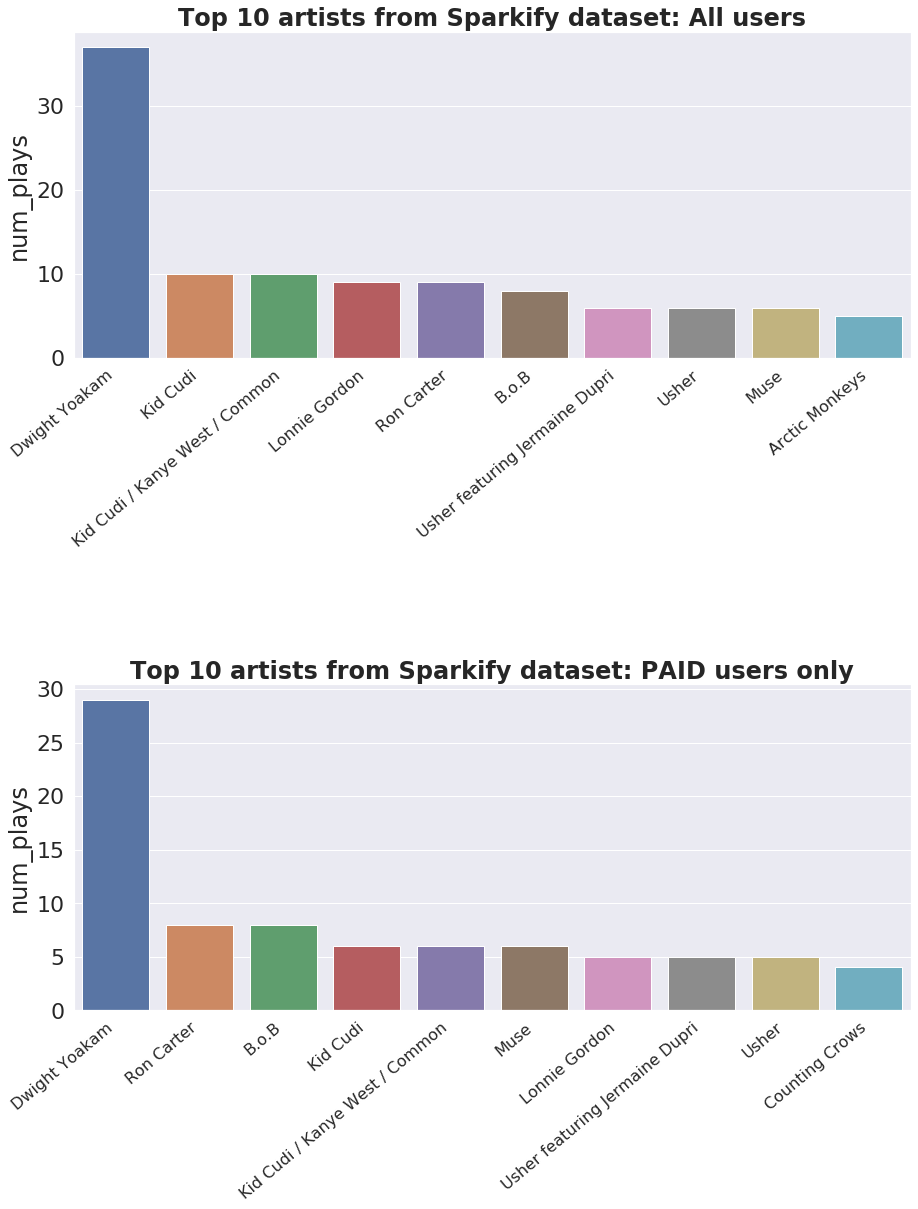

In [5]:
# Top artists for all users
query = ("""
    SELECT a.name AS artist_name, COUNT(*) AS num_plays 
    FROM songplays s 
    JOIN artists a
    ON s.artist_id = a.artist_id
    GROUP BY a.name 
    ORDER BY num_plays DESC 
    LIMIT 10;
""")
cur.execute(query)
colnames = [desc[0] for desc in cur.description]
results1 = pd.DataFrame(cur.fetchall(), columns = colnames)
#print(results1)

# Top artists just for paid users
query = ("""
    SELECT a.name AS artist_name, COUNT(*) AS num_plays 
    FROM songplays s
    JOIN artists a
    ON s.artist_id = a.artist_id
    AND s.level = 'paid'
    GROUP BY a.name 
    ORDER BY num_plays DESC 
    LIMIT 10;
""")
cur.execute(query)
colnames = [desc[0] for desc in cur.description]
results2 = pd.DataFrame(cur.fetchall(), columns = colnames)
#print(results2)

# Plot results as a Seaborn barplot (2 subplots)
fig, axes = plt.subplots(2, 1)
fig.subplots_adjust(hspace=1)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,18)})
sns.set(font_scale = 2)
plt.rcParams["xtick.labelsize"] = 16
chart1 = sns.barplot(x="artist_name", y="num_plays", data=results1, ax=axes[0]);
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=40, horizontalalignment='right');
chart1.set_title("Top 10 artists from Sparkify dataset: All users", weight = "bold");
chart1.set(xlabel=None)
chart2 = sns.barplot(x="artist_name", y="num_plays", data=results2, ax=axes[1]);
chart2.set_title("Top 10 artists from Sparkify dataset: PAID users only", weight = "bold");
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=40, horizontalalignment='right');
chart2.set(xlabel=None)

### Findings:
- No major differences in the music interests between all users and paid users (same artists, just in slightly different orders)  
- Dwight Yaokam is the most popular artist by far. This suggests many users enjoy country music.

### Suggestions for Udacity to improve project:
- Include some other fields such as song genre, and beats-per-minute, so we can do more in depth analysis of what users preferences are.

In [6]:
cur.close()
conn.close()